# LSTM
The purpose of this notebook is to use XGBoost for predicting hourly bike demand by station.

In [1]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from sklearn import datasets, svm

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

## Data Analysis and Exploration

In [2]:
# Import data
df = pd.read_csv('data/bike_temp_clean.csv')
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df.head()

,num_trips,start_datetime,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
0,0.0,2019-05-08,3185,0.0,1.0,1.0,0.0,2.0,5.0,6.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
1,1.0,2019-05-08,3638,518.0,4.0,0.0,0.0,4.0,8.0,2.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
2,0.0,2019-05-08,3681,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
3,0.0,2019-05-08,3206,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
4,1.0,2019-05-08,3639,1138.0,0.0,0.0,0.0,0.0,3.0,13.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108120 entries, 0 to 108119
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_trips             108120 non-null  float64       
 1   start_datetime        108120 non-null  datetime64[ns]
 2   start_station_id      108120 non-null  int64         
 3   avg_trip_duration     108120 non-null  float64       
 4   num_trips_1hr         108120 non-null  float64       
 5   num_trips_2hr         108120 non-null  float64       
 6   num_trips_3hr         108120 non-null  float64       
 7   num_trips_4hr         108120 non-null  float64       
 8   num_trips_5hr         108120 non-null  float64       
 9   num_trips_6hr         108120 non-null  float64       
 10  num_trips_24hr        108120 non-null  float64       
 11  num_trips_48hr        108120 non-null  float64       
 12  num_trips_week        108120 non-null  float64       
 13 

In [261]:
df.corr()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
num_trips,1.000000,-8.651456e-02,0.026238,0.623053,0.412487,0.280602,0.187954,0.126078,0.075991,0.645104,...,-1.095460e-02,-1.382883e-01,-1.350434e-01,1.264729e-02,-2.369475e-02,-2.426448e-03,1.310085e-02,3.067819e-02,1.289355e-01,1.867585e-01
start_station_id,-0.086515,1.000000e+00,-0.008129,-0.086513,-0.086533,-0.086552,-0.086556,-0.086599,-0.086634,-0.087014,...,-4.379510e-15,-5.918962e-16,-2.197016e-16,-1.863306e-15,6.676546e-15,-4.662539e-14,1.731880e-14,1.085718e-13,-9.821399e-17,4.689782e-17
avg_trip_duration,0.026238,-8.128621e-03,1.000000,0.013539,0.014179,0.013591,0.008553,0.005038,0.008570,0.014446,...,1.122812e-03,-2.209293e-02,-1.108456e-02,-7.365955e-03,3.140109e-03,-6.194547e-03,5.173688e-03,-6.137626e-04,-2.142133e-03,1.453659e-02
num_trips_1hr,0.623053,-8.651270e-02,0.013539,1.000000,0.623044,0.412512,0.280734,0.187983,0.125802,0.524449,...,-1.071153e-02,-1.666389e-01,-9.477703e-02,1.289275e-02,-2.244593e-02,-2.432374e-03,1.308366e-02,3.069263e-02,8.853101e-02,1.481493e-01
num_trips_2hr,0.412487,-8.653278e-02,0.014179,0.623044,1.000000,0.623163,0.412760,0.280887,0.187960,0.364094,...,-1.026169e-02,-1.845064e-01,-4.846764e-02,1.254297e-02,-2.120156e-02,-2.330127e-03,1.307567e-02,3.078773e-02,-3.334601e-02,7.564166e-02
num_trips_3hr,0.280602,-8.655248e-02,0.013591,0.412512,0.623163,1.000000,0.623075,0.412556,0.280275,0.256160,...,-1.034247e-02,-1.904579e-01,9.693432e-04,1.172402e-02,-2.108087e-02,-2.376047e-03,1.319408e-02,3.099217e-02,-1.119305e-01,2.083966e-02
num_trips_4hr,0.187954,-8.655564e-02,0.008553,0.280734,0.412760,0.623075,1.000000,0.622783,0.411562,0.174897,...,-1.002687e-02,-1.855824e-01,5.045313e-02,1.060466e-02,-2.200245e-02,-2.377448e-03,1.306356e-02,3.114109e-02,-1.434270e-01,1.079764e-02
num_trips_5hr,0.126078,-8.659940e-02,0.005038,0.187983,0.280887,0.412556,0.622783,1.000000,0.622131,0.122398,...,-8.907878e-03,-1.705455e-01,9.749289e-02,8.081044e-03,-2.451177e-02,-2.119300e-03,1.289841e-02,3.086302e-02,-1.513149e-01,5.952171e-03
num_trips_6hr,0.075991,-8.663401e-02,0.008570,0.125802,0.187960,0.280275,0.411562,0.622131,1.000000,0.080147,...,-5.759783e-03,-1.471379e-01,1.394947e-01,3.841325e-03,-3.008043e-02,-1.818318e-03,1.269827e-02,3.047645e-02,-1.487951e-01,4.244931e-03
num_trips_24hr,0.645104,-8.701449e-02,0.014446,0.524449,0.364094,0.256160,0.174897,0.122398,0.080147,1.000000,...,-6.261705e-03,-1.394011e-01,-1.349887e-01,-1.319319e-03,-2.869935e-02,1.044147e-03,1.245772e-02,2.950819e-02,1.280365e-01,1.883146e-01


In [262]:
df.describe()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,snow_depth,temp_max,temp_min,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month
count,108120.000000,108120.000000,1.081200e+05,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,...,108120.0,108120.000000,108120.000000,1.081200e+05,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000
mean,1.029403,3326.132075,3.791670e+02,1.029403,1.029292,1.029153,1.028811,1.028801,1.029273,1.029652,...,0.0,79.694118,64.611765,-6.545510e-17,0.041667,0.010189,0.135294,-0.054901,-0.063952,6.082353
std,2.432913,188.388673,8.127193e+03,2.432898,2.432888,2.432591,2.431369,2.430834,2.435043,2.435279,...,0.0,9.138228,8.349881,6.922219e-01,0.720487,0.657460,0.741180,0.708103,0.701067,0.800177
min,0.000000,3183.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,48.000000,42.000000,-9.976688e-01,-0.990686,-0.866025,-1.000000,-0.998717,-0.994869,5.000000
25%,0.000000,3201.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,73.000000,59.000000,-6.560249e-01,-0.626438,-0.866025,-0.500000,-0.724793,-0.758758,5.000000
50%,0.000000,3225.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,81.000000,66.000000,-1.224647e-16,0.067607,0.000000,0.500000,-0.101168,-0.050649,6.000000
75%,1.000000,3281.000000,3.440000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,87.000000,71.000000,6.560249e-01,0.725520,0.866025,1.000000,0.651372,0.688967,7.000000
max,70.000000,3792.000000,1.729020e+06,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,...,0.0,95.000000,82.000000,9.976688e-01,1.000000,0.866025,1.000000,0.998717,1.000000,7.000000


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


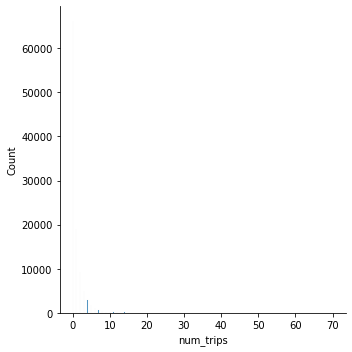

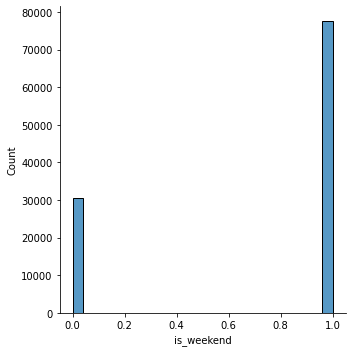

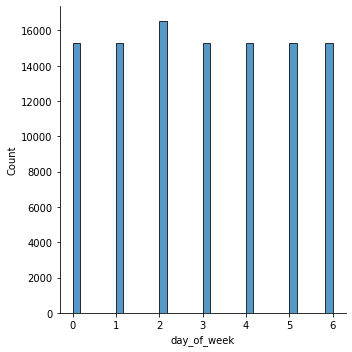

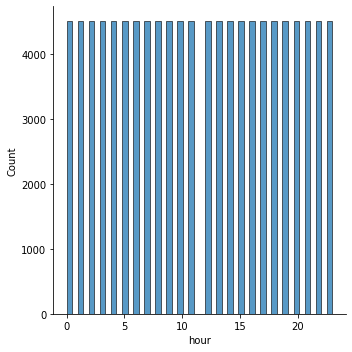

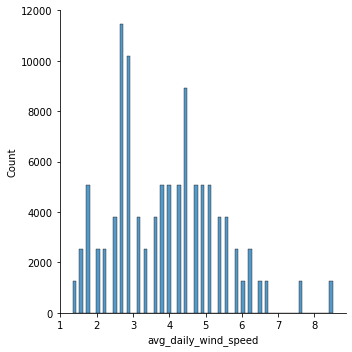

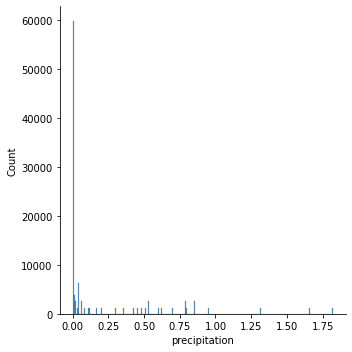

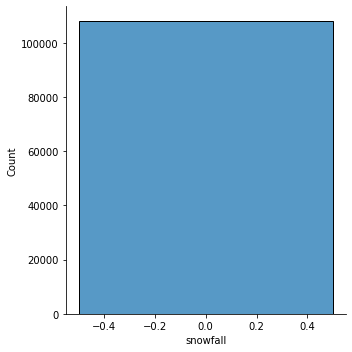

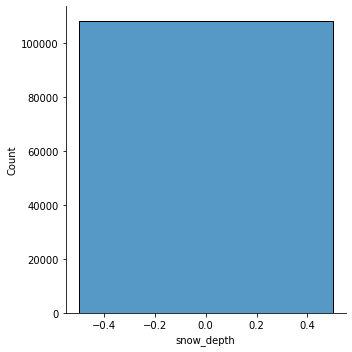

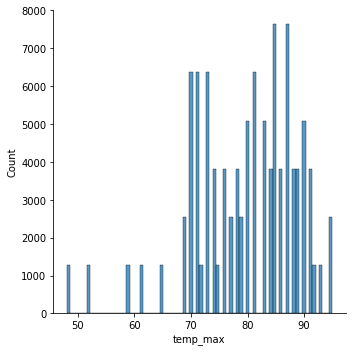

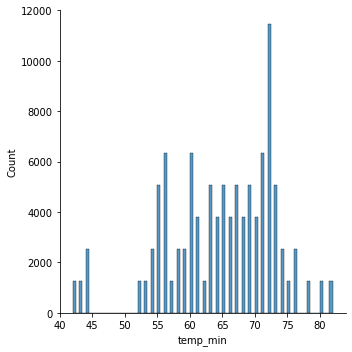

In [263]:
# Plot distribution of num_trips, is_weekend, day_of_week, and hour
sns.displot(df['num_trips'])
sns.displot(df['is_weekend'])
sns.displot(df['day_of_week'])
sns.displot(df['hour'])
sns.displot(df['avg_daily_wind_speed'])
sns.displot(df['precipitation'])
sns.displot(df['snowfall'])
sns.displot(df['snow_depth'])
sns.displot(df['temp_max'])
sns.displot(df['temp_min'])

Note that num_trips does not look like a Gaussian distribution, so lets transform to a logarithmic distribution.

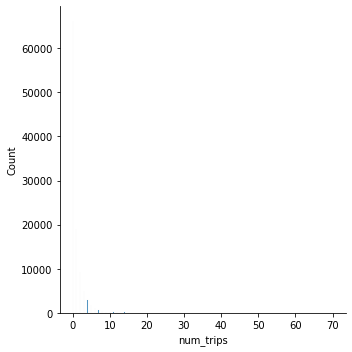

In [264]:
#df['num_trips_log'] = np.log1p(df['num_trips'])
#df = df.reindex(columns=['num_trips', 'num_trips_log', 'start_datetime', 'start_station_id', 'avg_trip_duration', 'is_weekend', 'day_of_week', 'hour'])
sns.displot(df['num_trips'])
#sns.displot(df['num_trips_log'])

Now lets plot the num_trips over time

<AxesSubplot:xlabel='start_datetime'>

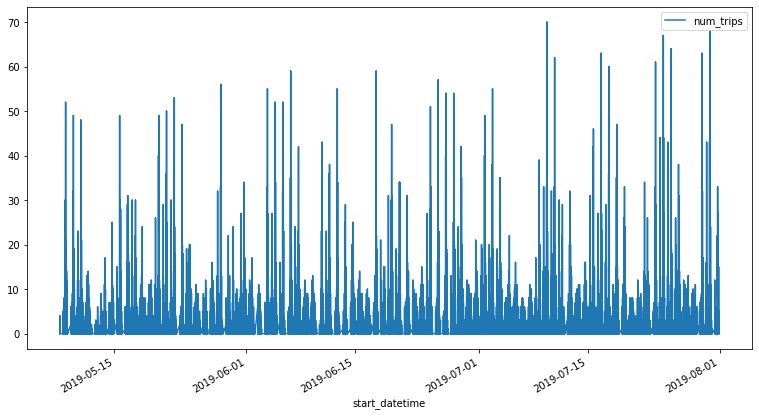

In [246]:
df.plot(x='start_datetime', y='num_trips', figsize=(13,7))

The number of trips appear to increase over the course of the month.

<AxesSubplot:xlabel='hour', ylabel='num_trips'>

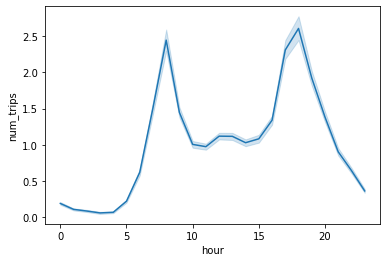

In [81]:
sns.lineplot(data=df, x='hour', y='num_trips')

The distribution of num_trips by hour appears to have two peaks in the AM and PM peak hours

<AxesSubplot:xlabel='start_datetime'>

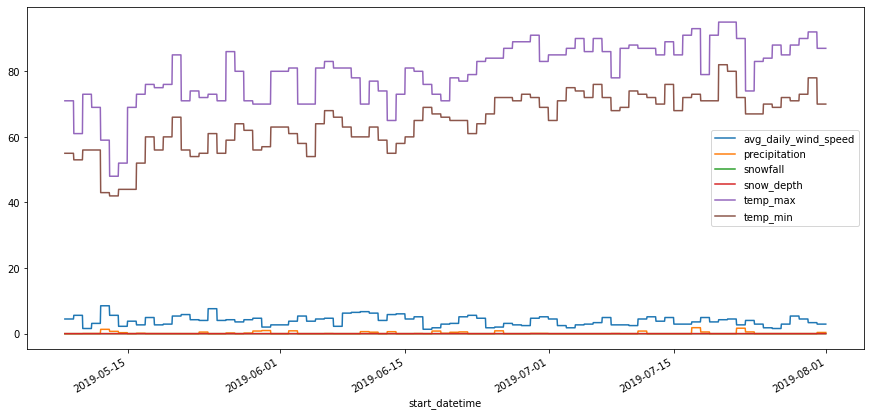

In [82]:
df.plot(x='start_datetime', y=['avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min'], figsize=(15,7))

In [265]:
df.columns

Index(['num_trips', 'start_datetime', 'start_station_id', 'avg_trip_duration',
       'num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr',
       'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr',
       'num_trips_week', 'day_of_week', 'day_of_month', 'is_weekend', 'hour',
       'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth',
       'temp_max', 'temp_min', 'fog', 'heavy_fog', 'thunder', 'haze',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'day_of_month_sin', 'day_of_month_cos', 'month', 'is_am_peak',
       'is_pm_peak'],
      dtype='object')

<AxesSubplot:>

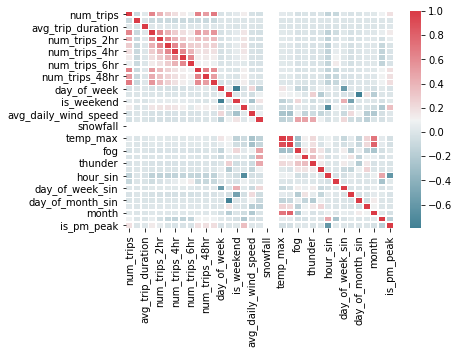

In [248]:
# Plot heatmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=cmap, linewidths=0.5)

Note that is_weekend and day_of_week are correlated and temp_min and temp_max are correlated. We should likely choose just one of them, but we will test this out with the XGBoost model and importance scores.

## Feature Engineering

In [3]:
# To use LSTM, we have to convert int to float64 types
#df['start_station_id'] = df['start_station_id'].astype('Float64')
df['day_of_week'] = df['day_of_week'].astype('Float64')
df['day_of_month'] = df['day_of_month'].astype('Float64')
df['hour'] = df['hour'].astype('Float64')
df['temp_max'] = df['temp_max'].astype('Float64')
df['temp_max'] = df['temp_max'].astype('Float64')
df['temp_min'] = df['temp_min'].astype('Float64')
df['month'] = df['month'].astype('Float64')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108120 entries, 0 to 108119
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_trips             108120 non-null  float64       
 1   start_datetime        108120 non-null  datetime64[ns]
 2   start_station_id      108120 non-null  int64         
 3   avg_trip_duration     108120 non-null  float64       
 4   num_trips_1hr         108120 non-null  float64       
 5   num_trips_2hr         108120 non-null  float64       
 6   num_trips_3hr         108120 non-null  float64       
 7   num_trips_4hr         108120 non-null  float64       
 8   num_trips_5hr         108120 non-null  float64       
 9   num_trips_6hr         108120 non-null  float64       
 10  num_trips_24hr        108120 non-null  float64       
 11  num_trips_48hr        108120 non-null  float64       
 12  num_trips_week        108120 non-null  float64       
 13 

## Train LSTM Model

### Testing Train/Test Sizes

In [15]:
# Split data into X, y
# X does not need previous counts, as it is included in LSTM
X = df.iloc[0:,1:]
X.drop(columns=['num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr', 'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr', 'num_trips_week'], inplace=True)

y = df.iloc[:,0:3]
y.reindex(columns=['start_datetime', 'start_station_id', 'num_trips'])

best_split = 0.20
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y, test_size=best_split, shuffle=False)

In [16]:
# LSTMs generally benefit from scaling the 

#f_columns = ['avg_trip_duration', 'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min', 'num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr', 'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr', 'num_trips_week']
f_columns = ['avg_trip_duration', 'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min']
cnt_columns = ['num_trips']

# feature, count transformers
# NOTE: Only scale the training data, we should not do this to the test data as it should be simulated as a dataset we do not know anything about
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(X_train_init[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(y_train_init[cnt_columns].to_numpy())

# Training data
X_train_init.loc[:,f_columns] = f_transformer.transform(X_train_init[f_columns].to_numpy())
y_train_init.loc[:,cnt_columns] = cnt_transformer.transform(y_train_init[cnt_columns].to_numpy())

# Test data
#X_test.loc[:,f_columns] = f_transformer.transform(X_test[f_columns].to_numpy())
#y_test.loc[:,cnt_columns] = cnt_transformer.transform(y_test[cnt_columns].to_numpy())

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [6]:
# Creates time-series data using subsequences
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    
    # Pivot X so there is one timestep for all combined station/variable combos
    X = X.pivot(index='start_datetime', columns='start_station_id', values=X.columns[2:])
    X.columns = ['%s%s' % (b, '|%s' % a if b else '') for a, b in X.columns]
    X.reset_index(inplace=True)
    # Pivot y so there is one timestep for all combined stations
    y = y.pivot(index='start_datetime', columns='start_station_id', values=['num_trips'])
    y.columns = ['%s%s' % (b, '|%s' % a if b else '') for a, b in y.columns]
    y.reset_index(inplace=True)
    
    # Determine total number of hours
    min_datetime = X.start_datetime.min()
    max_datetime = X.start_datetime.max()
    diff = max_datetime - min_datetime
    total_hours = int(((diff.days)*24) + (diff.seconds / 3600))

    i = 0
    for i in range(total_hours - time_steps):
        start_datetime = min_datetime + pd.Timedelta(hours=i)
        end_datetime = start_datetime + pd.Timedelta(hours=time_steps)
        # Get all X values >= start_datetime and < end_datetime
        vX = X.loc[(X['start_datetime'] >= start_datetime) & (X['start_datetime'] < end_datetime)]
        vX.drop(columns=['start_datetime'], inplace=True)
        Xs.append(vX.values)
        
        # Append sequence to ys
        vy = y.loc[(y['start_datetime'] == end_datetime)]
        vy.drop(columns=['start_datetime'], inplace=True)
        ys.append(vy.values)

        i += 1
        
    return np.asarray(Xs).astype(np.float32), np.asarray(ys).astype(np.float32)
    return Xs, ys

In [7]:
X_train, y_train = create_dataset(X_train_init, y_train_init, 72)
X_test, y_test = create_dataset(X_test_init, y_test_init, 72)

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
X_train.shape

(1463, 168, 1272)

In [14]:
y_train.shape

(1463, 1, 53)

In [15]:
X_test.shape

(239, 168, 1272)

In [16]:
y_test.shape

(239, 1, 53)

## Build Single-Output LSTM Model

In [11]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [12]:
# FOR SHAPES
# https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc
# CNN-LSTM https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_model(shape, hidden_nodes=900, optimizer='adam', activation='sigmoid', num_layers=1):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
      # First layer is bidirectional layer
      #keras.layers.Bidirectional(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      #)
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

### LSTM Model tuning

In [16]:
# https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

# https://github.com/kamran786/Bike-Sharing-Demand-Using-Tensorflow/blob/master/BikeSharing_Tensorflow.ipynb
# Implemented different 
# - Activation functions, 
# - Cost functions, 
# - Hidden layers, 
# - Hidden neurons, 
# - Gradient estimation, 
# - number of epochs, 
# - Network initialization 
# to improve the model accuracy.

# https://www.sciencedirect.com/science/article/pii/S1319157820303505
# On building the LSTM model, many hyper-parameters like activation function, loss function, and optimizer need to be set in advance. These hyper-parameters play a significant role in the performance of the DNNs.

# https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/
# Tuning number of epochs, batches, number of neurons


#### Validation Split

In [104]:
parameters = {
    'validation_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

42/42 [==============================] - 20s 410ms/step - loss: 2.2588 - val_loss: 2.3096
BEST PARAMS: {'validation_split': 0.1}

-2.198 (+/-0.171) for {'validation_split': 0.1}
-2.203 (+/-0.173) for {'validation_split': 0.2}
-2.206 (+/-0.161) for {'validation_split': 0.3}
-2.216 (+/-0.165) for {'validation_split': 0.4}
-2.227 (+/-0.165) for {'validation_split': 0.5}
-2.27 (+/-0.178) for {'validation_split': 0.6}
-2.322 (+/-0.2) for {'validation_split': 0.7}
-2.363 (+/-0.212) for {'validation_split': 0.8}
-2.499 (+/-0.221) for {'validation_split': 0.9}


In [105]:
print_results(cv)

BEST PARAMS: {'validation_split': 0.1}

-2.198 (+/-0.171) for {'validation_split': 0.1}
-2.203 (+/-0.173) for {'validation_split': 0.2}
-2.206 (+/-0.161) for {'validation_split': 0.3}
-2.216 (+/-0.165) for {'validation_split': 0.4}
-2.227 (+/-0.165) for {'validation_split': 0.5}
-2.27 (+/-0.178) for {'validation_split': 0.6}
-2.322 (+/-0.2) for {'validation_split': 0.7}
-2.363 (+/-0.212) for {'validation_split': 0.8}
-2.499 (+/-0.221) for {'validation_split': 0.9}


The best validation split is 0.1, but lets use 0.2 as it attains a similar RMSE and will better prevent overfitting of the model.

#### Number of Timesteps

In [10]:
# Lets test out the impact the number of timesteps has 
# day, two days, three days, week, two weeks
timesteps = [1, 3, 6, 10, 24, 48, 72, 168, 336]
training_data = {}

for timestep in timesteps:
    this_X_train, this_y_train = create_dataset(X_train_init, y_train_init, timestep)
    training_data[timestep] = [this_X_train, this_y_train]

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# Train on each individual dataset
for timestep in timesteps:
    train_data = training_data[timestep]
    
    # Create model
    grid_model = KerasRegressor(build_fn=build_model)
    parameters = {
        'validation_split': [0.2],
        'shape': [train_data[0].shape]
    }
    cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
    
    print(f"Training on {timestep} hours of data")

    cv.fit(train_data[0], train_data[1])
    print_results(cv)
    print("\n\n")

Training on 1 hours of data
41/41 [==============================] - 3s 42ms/step - loss: 2.1458 - val_loss: 2.1376
BEST PARAMS: {'shape': (1630, 1, 1272), 'validation_split': 0.2}

-2.154 (+/-0.137) for {'shape': (1630, 1, 1272), 'validation_split': 0.2}



Training on 3 hours of data
41/41 [==============================] - 4s 76ms/step - loss: 2.1628 - val_loss: 2.1326
BEST PARAMS: {'shape': (1628, 3, 1272), 'validation_split': 0.2}

-2.158 (+/-0.136) for {'shape': (1628, 3, 1272), 'validation_split': 0.2}



Training on 6 hours of data
41/41 [==============================] - 6s 122ms/step - loss: 2.1657 - val_loss: 2.1286
BEST PARAMS: {'shape': (1625, 6, 1272), 'validation_split': 0.2}

-2.156 (+/-0.139) for {'shape': (1625, 6, 1272), 'validation_split': 0.2}



Training on 10 hours of data
41/41 [==============================] - 9s 189ms/step - loss: 2.1453 - val_loss: 2.1289
BEST PARAMS: {'shape': (1621, 10, 1272), 'validation_split': 0.2}

-2.158 (+/-0.13) for {'shape': (1621,

24, 48, and 72 hours result in approximately the same RMSE. Lets use 72 hour timesteps.

In [12]:
X_train, y_train = create_dataset(X_train_init, y_train_init, 72)
X_test, y_test = create_dataset(X_test_init, y_test_init, 72)

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Number of Hidden Nodes (wider network)

In [62]:
# A rule of thumb for the number of hidden nodes is
# N_h = 2/3 * (N_i + N_o)
# N_ᵢ (number of input neurons) = 1272. 
# N_o (number of output neurons)= 53.
ni = 1272
no = 53
hidden_nodes = int((2/3) * (ni + no))
hidden_nodes

883

In [64]:
# Lets test a range of hidden_nodes

# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.2],
    'hidden_nodes': [50, 250, 500, 883, 1000]
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

39/39 [==============================] - 9s 214ms/step - loss: 2.1543 - val_loss: 2.0817
BEST PARAMS: {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}

-2.265 (+/-0.184) for {'hidden_nodes': 50, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.13 (+/-0.158) for {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.133 (+/-0.164) for {'hidden_nodes': 500, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.132 (+/-0.16) for {'hidden_nodes': 883, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.139 (+/-0.157) for {'hidden_nodes': 1000, 'shape': (1559, 72, 1272), 'validation_split': 0.2}


In [65]:
print_results(cv)

BEST PARAMS: {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}

-2.265 (+/-0.184) for {'hidden_nodes': 50, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.13 (+/-0.158) for {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.133 (+/-0.164) for {'hidden_nodes': 500, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.132 (+/-0.16) for {'hidden_nodes': 883, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.139 (+/-0.157) for {'hidden_nodes': 1000, 'shape': (1559, 72, 1272), 'validation_split': 0.2}


The best performing hidden_nodes is 250, so we will continue with that parameter.

#### Number of Layers (Deeper network)

In [73]:
def build_model_2_layers(shape, hidden_nodes=900, optimizer='adam', activation='sigmoid'):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation,
          return_sequences=True
        )
    )
    model.add(
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=int(hidden_nodes/2), 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      #)
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

def build_model_3_layers(shape, hidden_nodes=900, optimizer='adam', activation='sigmoid'):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation,
          return_sequences=True
        )
    )
    model.add(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=int(hidden_nodes/2), 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation,
          return_sequences=True
        )
    )
    model.add(
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=int(hidden_nodes/4), 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      #)
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

In [74]:
# Lets test if 1, 2, or 3 LSTM layers produces a better model


parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.2],
    'hidden_nodes': [250]
}

print("1 LSTM layer results")
grid_model = KerasRegressor(build_fn=build_model)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

print("2 LSTM layer results")
grid_model = KerasRegressor(build_fn=build_model_2_layers)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

print("3 LSTM layer results")
grid_model = KerasRegressor(build_fn=build_model_3_layers)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

1 LSTM layer results
39/39 [==============================] - 10s 223ms/step - loss: 2.1650 - val_loss: 2.0815
BEST PARAMS: {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}

-2.133 (+/-0.158) for {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}



2 LSTM layer results
39/39 [==============================] - 12s 265ms/step - loss: 2.1990 - val_loss: 2.0795
BEST PARAMS: {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}

-2.136 (+/-0.162) for {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}



3 LSTM layer results
39/39 [==============================] - 14s 289ms/step - loss: 2.2562 - val_loss: 2.1146
BEST PARAMS: {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}

-2.21 (+/-0.222) for {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}





1 LSTM layers performs the best.

#### Bidirectional LSTM Layer?

In [76]:
# DEFINE MODEL
def build_model_bidirectional(shape, hidden_nodes=900, optimizer='adam', activation='sigmoid', num_layers=1):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
      # First layer is bidirectional layer
      keras.layers.Bidirectional(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      )
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

In [77]:
parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.2],
    'hidden_nodes': [250]
}

print("Bidirectional LSTM Layer results")
grid_model = KerasRegressor(build_fn=build_model_bidirectional)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

Bidirectional LSTM Layer results
39/39 [==============================] - 19s 431ms/step - loss: 2.1422 - val_loss: 2.0813
BEST PARAMS: {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}

-2.136 (+/-0.173) for {'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}





The bidirectional layer does not appear to improve results.

#### Activation Function

In [82]:
# Activation function
# https://www.sciencedirect.com/science/article/pii/S1319157820303505
# sigmoid, hyperbolic tangent, Rectified Linear Unit (ReLU)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.2],
    'hidden_nodes': [250],
    'activation': [keras.activations.relu, 'sigmoid', 'tanh']
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

30/30 [==============================] - 15s 420ms/step - loss: nan - val_loss: nan


/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan -2.13353324 -2.13046238         nan]
  category=UserWarning


39/39 [==============================] - 22s 474ms/step - loss: 2.1458 - val_loss: 2.0895
BEST PARAMS: {'activation': 'tanh', 'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}

nan (+/-nan) for {'activation': <function relu at 0x14be68730>, 'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.134 (+/-0.167) for {'activation': 'sigmoid', 'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.13 (+/-0.167) for {'activation': 'tanh', 'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}
nan (+/-nan) for {'activation': 'relu', 'hidden_nodes': 250, 'shape': (1559, 72, 1272), 'validation_split': 0.2}


The tanh activation function produces the best results.

#### Optimizer

In [84]:
parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.2],
    'hidden_nodes': [250],
    'activation': ['tanh'],
    'optimizer': ['adam', 'Adadelta', 'SGD']
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

39/39 [==============================] - 21s 462ms/step - loss: 2.1501 - val_loss: 2.0816
BEST PARAMS: {'activation': 'tanh', 'hidden_nodes': 250, 'optimizer': 'adam', 'shape': (1559, 72, 1272), 'validation_split': 0.2}

-2.133 (+/-0.164) for {'activation': 'tanh', 'hidden_nodes': 250, 'optimizer': 'adam', 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.573 (+/-0.212) for {'activation': 'tanh', 'hidden_nodes': 250, 'optimizer': 'Adadelta', 'shape': (1559, 72, 1272), 'validation_split': 0.2}
-2.253 (+/-0.239) for {'activation': 'tanh', 'hidden_nodes': 250, 'optimizer': 'SGD', 'shape': (1559, 72, 1272), 'validation_split': 0.2}


The best optimizer is Adam.

#### Number of epochs

In [85]:
# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.2],
    'hidden_nodes': [250],
    'activation': ['tanh'],
    'optimizer': ['adam'],
    'epochs' : [5, 10, 20, 50, 100],
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)

Epoch 1/5
30/30 [==============================] - 8s 229ms/step - loss: 2.2333 - val_loss: 2.0497
Epoch 2/5
30/30 [==============================] - 6s 214ms/step - loss: 2.1885 - val_loss: 2.0453
Epoch 3/5
30/30 [==============================] - 6s 213ms/step - loss: 2.1726 - val_loss: 2.0474
Epoch 4/5
30/30 [==============================] - 7s 227ms/step - loss: 2.1723 - val_loss: 2.0441
Epoch 5/5
30/30 [==============================] - 7s 229ms/step - loss: 2.1805 - val_loss: 2.0458
Epoch 1/5
30/30 [==============================] - 8s 225ms/step - loss: 2.1581 - val_loss: 2.0504
Epoch 2/5
30/30 [==============================] - 6s 217ms/step - loss: 2.1165 - val_loss: 2.0500
Epoch 3/5
30/30 [==============================] - 7s 219ms/step - loss: 2.1129 - val_loss: 2.0464
Epoch 4/5
30/30 [==============================] - 7s 238ms/step - loss: 2.1104 - val_loss: 2.0480
Epoch 5/5
30/30 [==============================] - 7s 228ms/step - loss: 2.1126 - val_loss: 2.0458
Epoch 1/5


Epoch 3/20
30/30 [==============================] - 7s 232ms/step - loss: 2.1144 - val_loss: 2.0453
Epoch 4/20
30/30 [==============================] - 7s 219ms/step - loss: 2.1168 - val_loss: 2.0459
Epoch 5/20
30/30 [==============================] - 7s 230ms/step - loss: 2.1140 - val_loss: 2.0464
Epoch 6/20
30/30 [==============================] - 7s 230ms/step - loss: 2.1062 - val_loss: 2.0462
Epoch 7/20
30/30 [==============================] - 7s 229ms/step - loss: 2.1016 - val_loss: 2.0445
Epoch 8/20
30/30 [==============================] - 7s 225ms/step - loss: 2.0936 - val_loss: 2.0464
Epoch 9/20
30/30 [==============================] - 7s 221ms/step - loss: 2.1042 - val_loss: 2.0451
Epoch 10/20
30/30 [==============================] - 7s 222ms/step - loss: 2.0958 - val_loss: 2.0434
Epoch 11/20
30/30 [==============================] - 7s 220ms/step - loss: 2.0987 - val_loss: 2.0473
Epoch 12/20
30/30 [==============================] - 7s 225ms/step - loss: 2.1025 - val_loss: 2.04

30/30 [==============================] - 7s 223ms/step - loss: 2.0781 - val_loss: 2.0437
Epoch 6/50
30/30 [==============================] - 6s 218ms/step - loss: 2.0777 - val_loss: 2.0460
Epoch 7/50
30/30 [==============================] - 7s 221ms/step - loss: 2.0912 - val_loss: 2.0427
Epoch 8/50
30/30 [==============================] - 7s 227ms/step - loss: 2.0830 - val_loss: 2.0417
Epoch 9/50
30/30 [==============================] - 7s 242ms/step - loss: 2.0806 - val_loss: 2.0421
Epoch 10/50
30/30 [==============================] - 7s 242ms/step - loss: 2.0747 - val_loss: 2.0434
Epoch 11/50
30/30 [==============================] - 8s 281ms/step - loss: 2.0749 - val_loss: 2.0422
Epoch 12/50
30/30 [==============================] - 8s 267ms/step - loss: 2.0799 - val_loss: 2.0431
Epoch 13/50
30/30 [==============================] - 7s 234ms/step - loss: 2.0788 - val_loss: 2.0436
Epoch 14/50
30/30 [==============================] - 8s 281ms/step - loss: 2.0634 - val_loss: 2.0448
Epoch 

30/30 [==============================] - 7s 237ms/step - loss: 2.1478 - val_loss: 2.0425
Epoch 67/100
30/30 [==============================] - 7s 246ms/step - loss: 2.1516 - val_loss: 2.0441
Epoch 68/100
30/30 [==============================] - 7s 237ms/step - loss: 2.1598 - val_loss: 2.0428
Epoch 69/100
30/30 [==============================] - 7s 232ms/step - loss: 2.1362 - val_loss: 2.0420
Epoch 70/100
30/30 [==============================] - 7s 232ms/step - loss: 2.1459 - val_loss: 2.0440
Epoch 71/100
30/30 [==============================] - 7s 233ms/step - loss: 2.1483 - val_loss: 2.0430
Epoch 72/100
30/30 [==============================] - 7s 245ms/step - loss: 2.1526 - val_loss: 2.0429
Epoch 73/100
30/30 [==============================] - 8s 260ms/step - loss: 2.1565 - val_loss: 2.0443
Epoch 74/100
30/30 [==============================] - 8s 252ms/step - loss: 2.1516 - val_loss: 2.0449
Epoch 75/100
30/30 [==============================] - 7s 233ms/step - loss: 2.1464 - val_loss: 

30/30 [==============================] - 7s 239ms/step - loss: 2.0557 - val_loss: 2.0473
Epoch 27/100
30/30 [==============================] - 7s 241ms/step - loss: 2.0689 - val_loss: 2.0468
Epoch 28/100
30/30 [==============================] - 7s 242ms/step - loss: 2.0707 - val_loss: 2.0446
Epoch 29/100
30/30 [==============================] - 7s 242ms/step - loss: 2.0761 - val_loss: 2.0419
Epoch 30/100
30/30 [==============================] - 7s 251ms/step - loss: 2.0672 - val_loss: 2.0420
Epoch 31/100
30/30 [==============================] - 7s 239ms/step - loss: 2.0705 - val_loss: 2.0478
Epoch 32/100
30/30 [==============================] - 8s 259ms/step - loss: 2.0642 - val_loss: 2.0465
Epoch 33/100
30/30 [==============================] - 7s 234ms/step - loss: 2.0759 - val_loss: 2.0428
Epoch 34/100
30/30 [==============================] - 7s 241ms/step - loss: 2.0574 - val_loss: 2.0525
Epoch 35/100
30/30 [==============================] - 8s 266ms/step - loss: 2.0715 - val_loss: 

30/30 [==============================] - 8s 253ms/step - loss: 2.0416 - val_loss: 2.2706
Epoch 87/100
30/30 [==============================] - 7s 232ms/step - loss: 2.0327 - val_loss: 2.2705
Epoch 88/100
30/30 [==============================] - 7s 240ms/step - loss: 2.0460 - val_loss: 2.2703
Epoch 89/100
30/30 [==============================] - 7s 233ms/step - loss: 2.0533 - val_loss: 2.2692
Epoch 90/100
30/30 [==============================] - 8s 258ms/step - loss: 2.0456 - val_loss: 2.2698
Epoch 91/100
30/30 [==============================] - 8s 255ms/step - loss: 2.0389 - val_loss: 2.2697
Epoch 92/100
30/30 [==============================] - 7s 250ms/step - loss: 2.0463 - val_loss: 2.2698
Epoch 93/100
30/30 [==============================] - 7s 249ms/step - loss: 2.0428 - val_loss: 2.2702
Epoch 94/100
30/30 [==============================] - 7s 235ms/step - loss: 2.0495 - val_loss: 2.2759
Epoch 95/100
30/30 [==============================] - 7s 239ms/step - loss: 2.0528 - val_loss: 

Using 10 epochs reduces the RMSE the most.

### Final Model

In [17]:
# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.2],
    'hidden_nodes': [250],
    'activation': ['tanh'],
    'optimizer': ['adam'],
    'epochs' : [10],
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)

Epoch 1/10
30/30 [==============================] - 11s 317ms/step - loss: 2.2220 - val_loss: 2.0458
Epoch 2/10
30/30 [==============================] - 9s 297ms/step - loss: 2.1830 - val_loss: 2.0438
Epoch 3/10
30/30 [==============================] - 9s 318ms/step - loss: 2.1769 - val_loss: 2.0444
Epoch 4/10
30/30 [==============================] - 10s 327ms/step - loss: 2.1799 - val_loss: 2.0465
Epoch 5/10
30/30 [==============================] - 10s 328ms/step - loss: 2.1815 - val_loss: 2.0451
Epoch 6/10
30/30 [==============================] - 12s 392ms/step - loss: 2.1673 - val_loss: 2.0470
Epoch 7/10
30/30 [==============================] - 12s 398ms/step - loss: 2.1811 - val_loss: 2.0472
Epoch 8/10
30/30 [==============================] - 12s 383ms/step - loss: 2.1774 - val_loss: 2.0457
Epoch 9/10
30/30 [==============================] - 12s 414ms/step - loss: 2.1662 - val_loss: 2.0461
Epoch 10/10
30/30 [==============================] - 14s 471ms/step - loss: 2.1740 - val_loss

In [18]:
print_results(cv)

BEST PARAMS: {'activation': 'tanh', 'epochs': 10, 'hidden_nodes': 250, 'optimizer': 'adam', 'shape': (1559, 72, 1749), 'validation_split': 0.2}

-2.13 (+/-0.154) for {'activation': 'tanh', 'epochs': 10, 'hidden_nodes': 250, 'optimizer': 'adam', 'shape': (1559, 72, 1749), 'validation_split': 0.2}


The final model produces an RMSE of 2.13.

### Predict Test Data

In [41]:
# Predict test data
preds = cv.predict(X_test)
preds = cnt_transformer.inverse_transform(preds)
preds = preds.reshape(1,-1)[0]
preds[preds < 0] = 0

In [42]:
preds.shape

(17755,)

In [43]:
y_test_reshape = y_test.reshape(1,-1)[0]

In [44]:
y_test_reshape.shape

(17755,)

In [45]:
rmse = np.sqrt(mean_squared_error(y_test_reshape, preds))
print(f"RMSE of preds, y_test: {rmse}")

RMSE of preds, y_test: 2.630676507949829


The final model produces a 2.63 RMSE on the test data

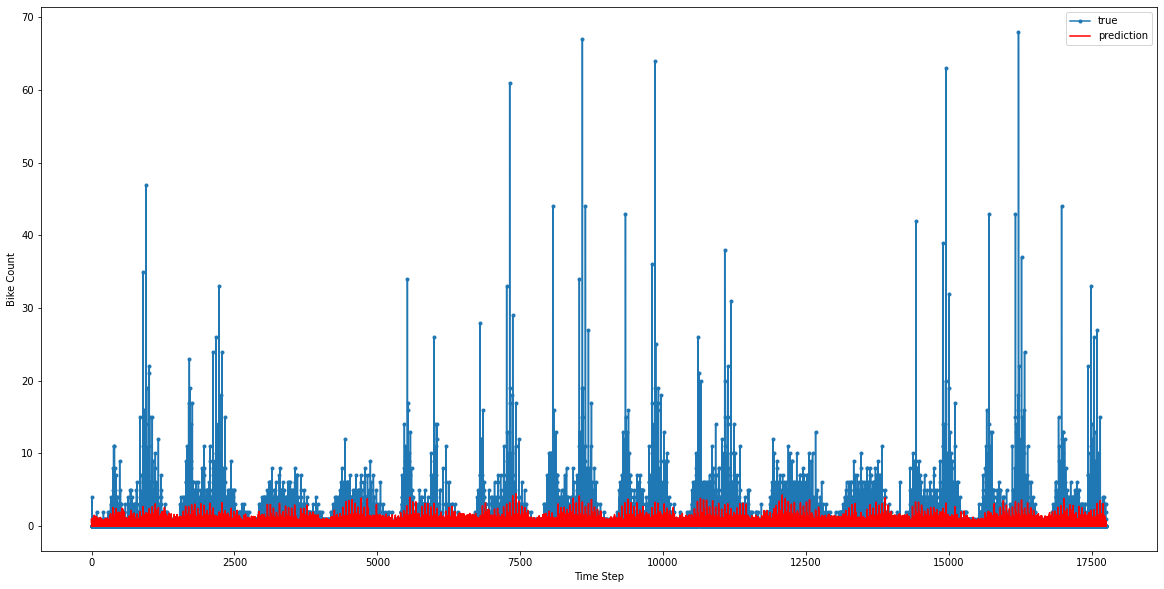

In [46]:
# Median station plot
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_test_reshape, marker='.', label="true")
plt.plot(preds, 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();